In [1]:
%load_ext autoreload

%autoreload 2

%load_ext snakeviz
import yaml
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.stats import chi2
import multiprocessing as mp

from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing

from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import lin_cost
from ruspy.estimation.estimation_cost_parameters import cost_func
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix

from ruspy.simulation.simulation import simulate
from ruspy.simulation.robust_sim import get_worst_trans

from ruspy.plotting.value_zero import discount_utility
from ruspy.plotting.value_zero import calc_ev_0

In [2]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 200 buses should be enough to gurantee convergence.
num_buses = 200
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 80000

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize)

#Initilize a dictionary with values needed on the way.
init_dict = {
    'estimation':{
        'groups': 'group_4',
        'beta': beta,
        'maint_func': 'linear',
        'binsize': 5000,
        'states': 90,
    },
    'simulation':{
        'beta': beta,
        'periods': num_periods,
        'seed': 123,
        'maint_func': 'linear',
        'buses': num_buses
    }
    
}
np.random.seed(init_dict['simulation']['seed'])

In [3]:
repl_data = data_processing(init_dict['estimation'])
trans_results, cost_results = estimate(init_dict['estimation'], repl_data)
print(trans_results, cost_results)

{'state_count': array([[68, 94,  9, ...,  0,  0,  0],
       [ 0, 44, 59, ...,  0,  0,  0],
       [ 0,  0, 47, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  1]]), 'x': array([0.39189189, 0.59529357, 0.01281454]), 'fun': 3140.5705570938244, 'trans_count': [1682, 2555, 55]}       fun: 163.585839925182
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.94759830e-05,  3.41060513e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 12
   status: 0
  success: True
        x: array([10.07770591,  2.29413601])


In [4]:
num_states = 100
init_dict['simulation']['params'] = [10, 50]
costs = cost_func(num_states, lin_cost, init_dict['simulation']['params'])

In [5]:
p_ml = trans_results['x']
init_dict['simulation']['known trans'] = p_ml
trans_mat_ml = create_transition_matrix(num_states, p_ml)
ev_ml = calc_fixp(num_states, trans_mat_ml, costs, beta)

In [51]:
cent_obs = np.percentile(np.sum(trans_results['state_count'], axis=1), 10)
worst_trans_cent = []
for omega in np.arange(0.9, 1, 0.01):
    rho = chi2.ppf(omega, len(p_ml) - 1) / (2 * cent_obs)
    worst_trans = get_worst_trans(init_dict['simulation'], rho, num_states)
    worst_trans_cent +=[worst_trans]

In [52]:
worst_trans_cent

[array([0.12566805, 0.80930372, 0.06502823]),
 array([0.12138022, 0.81105035, 0.06756943]),
 array([0.11673718, 0.81290104, 0.07036178]),
 array([0.11175346, 0.81466535, 0.07358119]),
 array([0.10633983, 0.81629885, 0.07736132]),
 array([0.10036067, 0.817733  , 0.08190633]),
 array([0.09357281, 0.81889742, 0.08752977]),
 array([0.0857686 , 0.81916603, 0.09506537]),
 array([0.07612361, 0.81794736, 0.10592903]),
 array([0.06272645, 0.81213978, 0.12513377])]

In [40]:
init_dict['simulation']['ev_known'] = ev_ml

v_strat_opt = []
for p in worst_trans_cent:
    init_dict_real = copy.deepcopy(init_dict['simulation'])
    init_dict_real['real trans'] = p
    df, unobs, utilities, num_states = simulate(init_dict_real)
    trans_mat_worst = create_transition_matrix(num_states, p)
    v_strat_opt += [calc_ev_0(calc_fixp(num_states, trans_mat_worst, costs, beta), unobs, num_buses)]
    v_strat_ml += [discount_utility([0., 0.], num_buses, num_periods, num_periods, utilities, beta)[-1]]

[0.12566805 0.80930372 0.06502823]
[0.12138022 0.81105035 0.06756943]
[0.11673718 0.81290104 0.07036178]
[0.11175346 0.81466535 0.07358119]
[0.10633983 0.81629885 0.07736132]
[0.10036067 0.817733   0.08190633]
[0.09357281 0.81889742 0.08752977]
[0.0857686  0.81916603 0.09506537]
[0.07612361 0.81794736 0.10592903]
[0.06272645 0.81213978 0.12513377]


In [ ]:
p = worst_trans_cent[0]
init_dict['real trans'] = p
df, unobs, utilities, num_states = simulate(init_dict_real)
trans_mat_worst = create_transition_matrix(num_states, p)
v_strat_opt += [calc_ev_0(calc_fixp(num_states, trans_mat_worst, costs, beta), unobs, num_buses)]
v_strat_ml += [discount_utility([0., 0.], num_buses, num_periods, num_periods, utilities, beta)[-1]]

In [55]:
v_strat_opt[0]

-8144.717923228919

In [46]:
np.savetxt("ml_opt.txt", np.array([v_strat_ml, v_strat_opt]))

In [47]:
v_exp_fig_1 = np.full(num_points, v_strat_opt[0])

In [70]:
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 5000,
  'states': 90},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 200,
  'params': [10, 50]}}

In [75]:
num_states

200

In [73]:
p_test = worst_trans_cent[0]
trans_mat_test = create_transition_matrix(num_states, p_test)
calc_fixp_test = calc_fixp(num_states, trans_mat_test, costs, beta)
p_test

array([0.12566805, 0.80930372, 0.06502823])

In [74]:
init_dict_test = copy.deepcopy(init_dict['simulation'])
init_dict_test['ev_known'] = calc_fixp_test
init_dict_test['real trans'] = p_test

In [76]:
df_test, unobs_test, utilities_test, num_states_test = simulate(init_dict_test)

In [77]:
v_exp_fig_1 = np.full(num_points, calc_ev_0(calc_fixp_test, unobs_test, num_buses))

In [81]:
v_disc_fig_1

array([    0.        ,  -771.2883843 , -1472.15924499, -2107.22617908,
       -2680.59123762, -3198.89141523, -3671.32477606, -4094.58990116,
       -4480.96431116, -4827.60286142, -5142.85380179, -5425.93627035,
       -5683.72179275, -5916.8367041 , -6129.09326778, -6321.44455315,
       -6495.19681588, -6651.2320171 , -6793.00838987, -6921.56495187,
       -7037.90604442, -7142.41706512, -7237.28371009, -7322.82928082,
       -7400.46377941, -7471.14830625, -7534.8981771 , -7592.28794285,
       -7644.24685047, -7691.31133446, -7734.0416949 , -7772.42628799,
       -7807.4605895 , -7839.09556729, -7867.53830275, -7893.49444068,
       -7916.80706903, -7937.93396165, -7956.98243316, -7974.28984303,
       -7989.96927102, -8004.16138464, -8017.00725399, -8028.65818264,
       -8039.19520573, -8048.7644822 , -8057.36263736, -8065.17225021,
       -8072.22459433, -8078.61604547, -8084.35852507, -8089.59588097,
       -8094.32300023, -8098.59483832, -8102.46315997, -8105.95787309,
      

In [78]:
v_disc_fig_1 = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities_test, beta)

[]

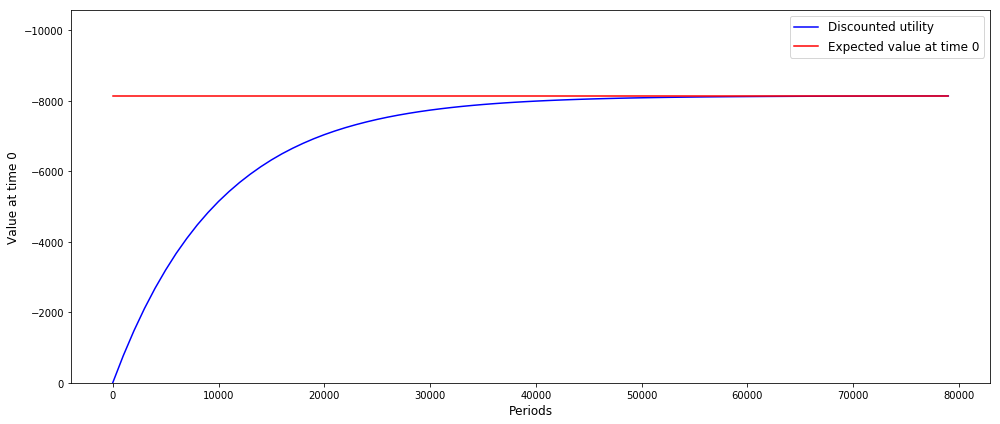

In [79]:
periods = np.arange(0, num_periods, gridsize)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1.3 * v_disc_fig_1[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=12)
ax.set_xlabel(r"Periods", fontsize=12)
ax.plot(periods, v_disc_fig_1, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_fig_1, color='red', label='Expected value at time 0')



plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

In [64]:
np.mean(unobs[:, 0, 0])

0.08004200407592048

In [39]:
v_strat_090 = []
cent_obs = np.percentile(np.sum(trans_results['state_count'], axis=1), 10)
rho = chi2.ppf(0.9, len(p_ml) - 1) / (2 * cent_obs)
worst_trans_090 = get_worst_trans(init_dict['simulation'], rho, num_states)
trans_mat_worst_090 = create_transition_matrix(num_states, worst_trans_090)
init_dict['simulation']['ev_known'] = calc_fixp(num_states, trans_mat_worst_090, costs, beta)
for worst_trans in worst_trans_cent:
    init_dict_real = copy.deepcopy(init_dict['simulation'])
    init_dict_real['real trans'] = worst_trans
    df, unobs, utilities, num_states = simulate(init_dict_real)
    v_strat_090 += [discount_utility([0., 0.], num_buses, num_periods, num_periods, utilities, beta)[-1]]

[0.12566805 0.80930372 0.06502823]
[-0.75307652  0.51025646]
[0.12138022 0.81105035 0.06756943]
[-0.75307652  0.51025646]
[0.11673718 0.81290104 0.07036178]
[-0.75307652  0.51025646]
[0.11175346 0.81466535 0.07358119]
[-0.75307652  0.51025646]
[0.10633983 0.81629885 0.07736132]
[-0.75307652  0.51025646]
[0.10036067 0.817733   0.08190633]
[-0.75307652  0.51025646]
[0.09357281 0.81889742 0.08752977]
[-0.75307652  0.51025646]
[0.0857686  0.81916603 0.09506537]
[-0.75307652  0.51025646]
[0.07612361 0.81794736 0.10592903]
[-0.75307652  0.51025646]
[0.06272645 0.81213978 0.12513377]
[-0.75307652  0.51025646]


In [44]:
v_strat_090[0] - v_strat_opt[0]

8.247094146570817

In [14]:
np.savetxt("090.txt", np.array(v_strat_090))

In [15]:
v_strat_099 = []
mean_obs = np.percentile(np.sum(trans_results['state_count'], axis=1), 10)
rho = chi2.ppf(0.99, len(p_ml) - 1) / (2 * cent_obs)
worst_trans = get_worst_trans(init_dict['simulation'], rho, num_states)
trans_mat_worst = create_transition_matrix(num_states, worst_trans)
init_dict['simulation']['ev_known'] = calc_fixp(num_states, trans_mat_worst, costs, beta)
for omega in np.arange(0.9, 1, 0.01):
    rho = chi2.ppf(omega, len(p_ml) - 1) / (2 * mean_obs)
    worst_trans = get_worst_trans(init_dict['simulation'], rho, num_states)
    init_dict_real = copy.deepcopy(init_dict['simulation'])
    init_dict_real['real trans'] = worst_trans
    df, unobs, utilities, num_states = simulate(init_dict_real)
    v_strat_099 += [discount_utility([0., 0.], num_buses, num_periods, num_periods, utilities, beta)[-1]]

In [16]:
np.savetxt("099.txt", np.array(v_strat_099))

In [17]:
omega_range = np.arange(0.9, 1, 0.01)

[]

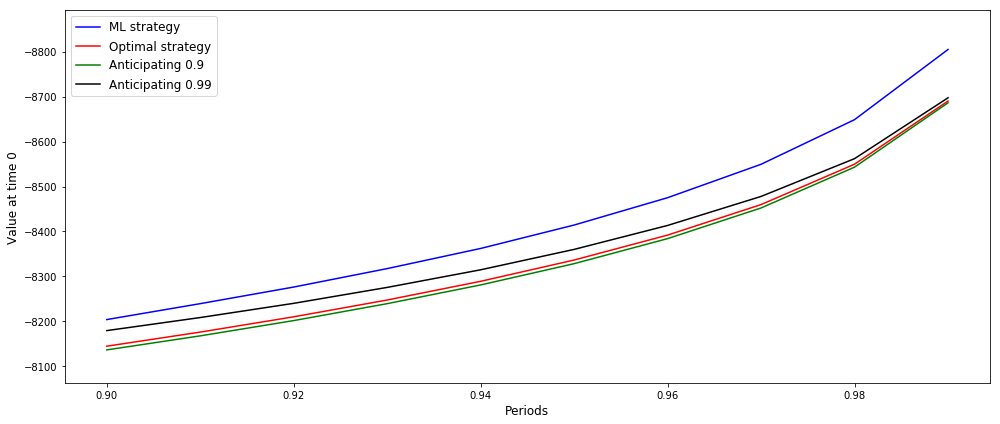

In [41]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0.99 * v_strat_opt[0], 1.01 * v_strat_ml[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=12)
ax.set_xlabel(r"Periods", fontsize=12)
ax.plot(omega_range, v_strat_ml, color='blue', label='ML strategy')
ax.plot(omega_range, v_strat_opt, color='red', label='Optimal strategy')
ax.plot(omega_range, v_strat_090, color='green', label='Anticipating 0.9')
ax.plot(omega_range, v_strat_099, color='black', label='Anticipating 0.99')



plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()


In [74]:
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 5000,
  'states': 90},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 200,
  'params': [10, 50],
  'ev_known': array([-9470.80570289, -9471.51980637, -9472.19417696, -9472.82888861,
         -9473.42407192, -9473.97994483, -9474.49685236, -9474.97531313,
         -9475.41606806, -9475.82012332, -9476.18877885, -9476.52363425,
         -9476.8265676 , -9477.09968794, -9477.34526767, -9477.56566436,
         -9477.76324273, -9477.94030555, -9478.09903916, -9478.24147564,
         -9478.36947112, -9478.48469745, -9478.58864421, -9478.68262777,
         -9478.76780447, -9478.84518607, -9478.91565559, -9478.97998278,
         -9479.03883856, -9479.09280807, -9479.1424023 , -9479.18806822,
         -9479.2301977 , -9479.26913503, -9479.30518355, -9479.33861117,
         -9479.36965519, -9479.39852638, -9479.42541244, -9479.45048098,
         -

In [68]:
init_dict['simulation']['ev_known'] = ev_ml
v_strat_ml_mean = []
v_strat_opt_mean = []
mean_obs = np.mean(np.sum(trans_results['state_count'], axis=1))
for omega in np.arange(0.9, 1, 0.01):
    roh = chi2.ppf(omega, len(p_ml) - 1) / (2 * mean_obs)
    worst_trans = get_worst_trans(init_dict['simulation'], roh, num_states)
    trans_mat_worst = create_transition_matrix(num_states, worst_trans)
    v_strat_opt_mean += [calc_fixp(num_states, trans_mat_worst, costs, beta)[0]]
    init_dict_real = copy.deepcopy(init_dict['simulation'])
    init_dict_real['real trans'] = worst_trans
    df, unobs, utilities, num_states = simulate(init_dict_real)
    v_strat_ml_mean += [discount_utility([0., 0.], num_buses, num_periods, num_periods, utilities, beta)[-1]]

[]

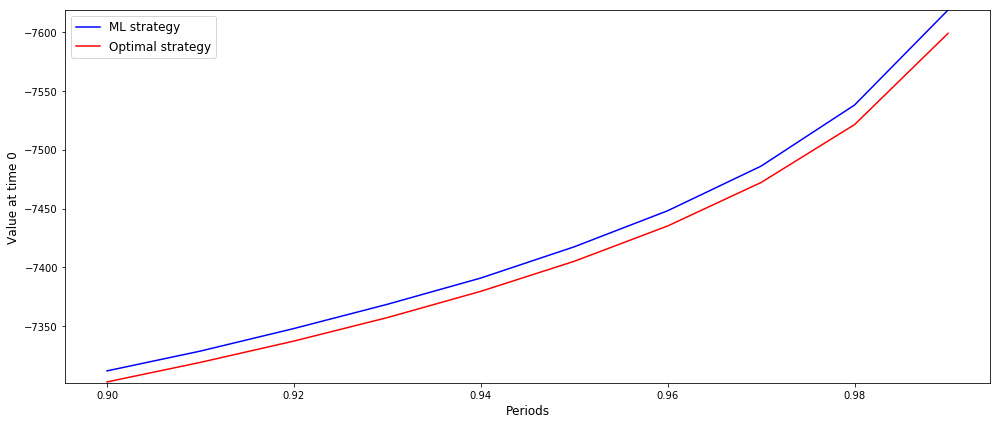

In [70]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0.9999 * v_strat_opt_mean[0], 1.00001 * v_strat_ml_mean[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=12)
ax.set_xlabel(r"Periods", fontsize=12)
ax.plot(omega_range, v_strat_ml_mean, color='blue', label='ML strategy')
ax.plot(omega_range, v_strat_opt_mean, color='red', label='Optimal strategy')



plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()
